In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

2022-01-22 18:04:50.675699: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2022-01-22 18:04:51.757507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-22 18:04:51.795271: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2799925000 Hz
2022-01-22 18:04:51.795934: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a02b65e2a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-22 18:04:51.795961: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-22 18:04:51.798970: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-22 18:04:51.878661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [2]:
def add_layer(tensor):
    return tensor[0] + tensor[1]

def mul_layer(tensor):
    return tensor[0] * tensor[1]

def div_layer(tensor):
    return tensor[0] / tensor[1]

def sub_layer(tensor):
    return tensor[0] - tensor[1]

def neg_layer(tensor):
    return -tensor

def cos_layer(tensor):
    return tf.math.cos(tensor)

def sin_layer(tensor):
    return tf.math.sin(tensor)

# Model

In [3]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

# feature extraction from right image
right_img = Input(shape = (112,112,3), name="right_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

right_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=right_img, input_shape=(112,112,3))
right_phi_features = right_phi_model.output
right_flat = Flatten(name='right-phi-flattened')(right_phi_features)

concat = concatenate([left_flat, right_flat])

# fx
dense_1 = Dense(120, activation = 'relu')(concat)
dense_2 = Dense(84, activation = 'relu')(dense_1)
pred_fx = Dense(1, name='fx')(dense_2)

# fy
dense_3 = Dense(120, activation = 'relu')(concat)
dense_4 = Dense(84, activation = 'relu')(dense_3)
pred_fy = Dense(1, name='fy')(dense_4)

# u0
dense_5 = Dense(120, activation = 'relu')(concat)
dense_6 = Dense(84, activation = 'relu')(dense_5)
pred_u0 = Dense(1, name='u0')(dense_6)

# v0
dense_7 = Dense(120, activation = 'relu')(concat)
dense_8 = Dense(84, activation = 'relu')(dense_7)
pred_v0 = Dense(1, name='v0')(dense_8)

# baseline
dense_9 = Dense(120, activation = 'relu')(concat)
dense_10 = Dense(84, activation = 'relu')(dense_9)
pred_baseline = Dense(1, name='baseline')(dense_10)

# tx
dense_11 = Dense(120, activation = 'relu')(concat)
dense_12 = Dense(84, activation = 'relu')(dense_11)
pred_x = Dense(1, name='x')(dense_12)

# ty
dense_13 = Dense(120, activation = 'relu')(concat)
dense_14 = Dense(84, activation = 'relu')(dense_13)
pred_y = Dense(1, name='y')(dense_14)

# tz
dense_15 = Dense(120, activation = 'relu')(concat)
dense_16 = Dense(84, activation = 'relu')(dense_15)
pred_z = Dense(1, name='z')(dense_16)

# pitch
dense_17 = Dense(120, activation = 'relu')(concat)
dense_18 = Dense(84, activation = 'relu')(dense_17)
pred_pitch = Dense(1, name='pitch')(dense_18)

# u
dense_19 = Dense(120, activation = 'relu')(concat)
dense_20 = Dense(84, activation = 'relu')(dense_19)
pred_u = Dense(1, name='u')(dense_20)

# v
dense_21 = Dense(120, activation = 'relu')(concat)
dense_22 = Dense(84, activation = 'relu')(dense_21)
pred_v = Dense(1, name='v')(dense_22)

# disparity
dense_23 = Dense(120, activation = 'relu')(concat)
dense_24 = Dense(84, activation = 'relu')(dense_23)
pred_disparity = Dense(1, name='disparity')(dense_24)

# w_xcam
dense_25 = Dense(120, activation = 'relu')(concat)
dense_26 = Dense(84, activation = 'relu')(dense_25)
w_xcam = Dense(1, name='w_xcam', activation = 'sigmoid')(dense_26)

# w_ycam
dense_27 = Dense(120, activation = 'relu')(concat)
dense_28 = Dense(84, activation = 'relu')(dense_27)
w_ycam = Dense(1, name='w_ycam', activation = 'sigmoid')(dense_28)

# w_zcam
dense_29 = Dense(120, activation = 'relu')(concat)
dense_30 = Dense(84, activation = 'relu')(dense_29)
w_zcam = Dense(1, name='w_zcam', activation = 'sigmoid')(dense_30)

# w_xworld
dense_31 = Dense(120, activation = 'relu')(concat)
dense_32 = Dense(84, activation = 'relu')(dense_31)
w_xworld = Dense(1, name='w_xworld', activation = 'sigmoid')(dense_32)

# w_yworld
dense_33 = Dense(120, activation = 'relu')(concat)
dense_34 = Dense(84, activation = 'relu')(dense_33)
w_yworld = Dense(1, name='w_yworld', activation = 'sigmoid')(dense_34)

# w_zworld
dense_35 = Dense(120, activation = 'relu')(concat)
dense_36 = Dense(84, activation = 'relu')(dense_35)
w_zworld = Dense(1, name='w_zworld', activation = 'sigmoid')(dense_36)


# xCam = (self.intrinsic.fx * self.extrinsic.baseline) / disparity
mul_1 = Lambda(mul_layer)([pred_fx, pred_baseline])
xCam = Lambda(div_layer)([mul_1, pred_disparity])
xCam = Lambda(mul_layer, name='xCam')([xCam, w_xcam])

# yCam = - (xCam / self.intrinsic.fx) * (u - self.intrinsic.u0)
div_1 = Lambda(div_layer)([xCam, pred_fx])
sub_1 = Lambda(sub_layer)([pred_u, pred_u0])
yCam = Lambda(mul_layer)([Lambda(neg_layer)(div_1), sub_1])
yCam = Lambda(mul_layer, name='yCam')([yCam, w_ycam])

# zCam = (xCam / self.intrinsic.fy) * (self.intrinsic.v0 - v)
div_2 = Lambda(div_layer)([xCam, pred_fy])
sub_2 = Lambda(sub_layer)([pred_v0, pred_v])
zCam = Lambda(mul_layer)([div_2, sub_2])
zCam = Lambda(mul_layer, name='zCam')([zCam, w_zcam])

# Y = yCam + self.extrinsic.y
pred_yWorld = Lambda(add_layer)([yCam, pred_y])
pred_yWorld = Lambda(mul_layer, name='yWorld')([pred_yWorld, w_yworld])

# X = xCam * math.cos(self.extrinsic.pitch) + zCam * math.sin(self.extrinsic.pitch) + self.extrinsic.x
mul_2 = Lambda(mul_layer)([xCam, Lambda(cos_layer)(pred_pitch)])
mul_3 = Lambda(mul_layer)([zCam, Lambda(sin_layer)(pred_pitch)])
add_1 = Lambda(add_layer)([mul_2, mul_3])
pred_xWorld = Lambda(add_layer)([add_1, pred_x])
pred_xWorld = Lambda(mul_layer, name='xWorld')([pred_xWorld, w_xworld])

# Z = - xCam * math.sin(self.extrinsic.pitch) + zCam * math.cos(self.extrinsic.pitch) + self.extrinsic.z
mul_4 = Lambda(mul_layer)([Lambda(neg_layer)(xCam), Lambda(sin_layer)(pred_pitch)])
mul_5 = Lambda(mul_layer)([zCam, Lambda(cos_layer)(pred_pitch)])
add_2 = Lambda(add_layer)([mul_4, mul_5])
pred_zWorld = Lambda(add_layer)([add_2, pred_z])
pred_zWorld = Lambda(mul_layer, name='zWorld')([pred_zWorld, w_zworld])

# create model
model = Model(inputs=[left_img, right_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
#plot_model(model, to_file='model.png')


2022-01-22 18:04:57.502469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 18:04:57.502752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-22 18:04:57.502783: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-22 18:04:57.502807: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-22 18:04:57.502818: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-01-22 18:04:57.502830: I tensorflow/stream_executor/

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 55, 55, 32)   864         right_image[0][0]                
_______________________________________________________________________________________

# Get data

In [4]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
X = np.load(data_path+"x.npy")
Y = np.load(data_path+"y.npy") 
Z = np.load(data_path+"z.npy")


In [6]:
print ("dataset: ",np.shape(Z))

dataset:  (79320,)


In [6]:
print ("Training Dataset: ",len(Left_images)*0.7, "Test Dataset: ", len(Left_images)*0.3)

Training Dataset:  55524.0 Test Dataset:  23796.0


In [8]:
import os
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

model_name = 'model_multi_class/'
SAVE = "new_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
# Save
output_folder = SAVE + model_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_log = output_folder + "Log/"
if not os.path.exists(output_log):
    os.makedirs(output_log)

output_weight = output_folder + "Best/"
if not os.path.exists(output_weight):
    os.makedirs(output_weight)


input_shape = (112, 112, 3)

tensorboard = TensorBoard(log_dir=output_log)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

csv_logger = CSVLogger('training.log')

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=output_weight + "weights_{epoch:02d}_{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    x=[Left_images[:int(len(Left_images)*0.7)], Right_images[:int(len(Left_images)*0.7)]],
    y=[Fx[:int(len(Left_images)*0.7)], Fy[:int(len(Left_images)*0.7)], U0[:int(len(Left_images)*0.7)], V0[:int(len(Left_images)*0.7)], Baseline[:int(len(Left_images)*0.7)], Disparity[:int(len(Left_images)*0.7)], Tx[:int(len(Left_images)*0.7)], Ty[:int(len(Left_images)*0.7)], Tz[:int(len(Left_images)*0.7)], Pitch[:int(len(Left_images)*0.7)], X[:int(len(Left_images)*0.7)], Y[:int(len(Left_images)*0.7)], Z[:int(len(Left_images)*0.7)]],
    batch_size=16,
    epochs=200,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    validation_data=([Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]], [Fx[int(len(Left_images)*0.7):], Fy[int(len(Left_images)*0.7):], U0[int(len(Left_images)*0.7):], V0[int(len(Left_images)*0.7):], Baseline[int(len(Left_images)*0.7):], Disparity[int(len(Left_images)*0.7):], Tx[int(len(Left_images)*0.7):], Ty[int(len(Left_images)*0.7):], Tz[int(len(Left_images)*0.7):], Pitch[int(len(Left_images)*0.7):], X[int(len(Left_images)*0.7):], Y[int(len(Left_images)*0.7):], Z[int(len(Left_images)*0.7):]]),
    callbacks=[tensorboard, checkpointer, early_stopping, csv_logger]
)

Train on 55524 samples, validate on 23796 samples
Epoch 1/200


2022-01-12 23:19:17.626742: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-12 23:19:19.975196: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-01-12 23:19:28.290197: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-12 23:19:28.310114: W tensorflow/core/common_runtime/bfc_allocator.cc:312] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try s

   16/55524 [..............................] - ETA: 0s - loss: 388.2094 - fx_loss: 64.4087 - fy_loss: 64.8913 - u0_loss: 55.2321 - v0_loss: 56.0328 - baseline_loss: 2.0401 - disparity_loss: 5.4619 - x_loss: 2.5783 - y_loss: 2.3349 - z_loss: 2.8164 - pitch_loss: 74.0557 - xWorld_loss: 21.8864 - yWorld_loss: 19.6278 - zWorld_loss: 16.8430

2022-01-12 23:19:31.983935: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-01-12 23:19:31.986384: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-01-12 23:19:32.140816: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-01-12 23:19:32.246798: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


   32/55524 [..............................] - ETA: 27:45 - loss: 444.7425 - fx_loss: 69.9482 - fy_loss: 72.0970 - u0_loss: 47.9923 - v0_loss: 52.3932 - baseline_loss: 2.8930 - disparity_loss: 7.5533 - x_loss: 4.5724 - y_loss: 6.1592 - z_loss: 7.8608 - pitch_loss: 84.1341 - xWorld_loss: 30.4256 - yWorld_loss: 22.9547 - zWorld_loss: 35.7587

2022-01-12 23:19:32.621733: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-01-12 23:19:32.758972: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: new_logs/20220112-231840/model_multi_class/Log/plugins/profile/2022_01_12_23_19_32
2022-01-12 23:19:32.768570: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to new_logs/20220112-231840/model_multi_class/Log/plugins/profile/2022_01_12_23_19_32/talha-Inspiron-15-7000-Gaming.trace.json.gz
2022-01-12 23:19:32.904394: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: new_logs/20220112-231840/model_multi_class/Log/plugins/profile/2022_01_12_23_19_32
2022-01-12 23:19:32.910506: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to new_logs/20220112-231840/model_multi_class/Log/plugins/pr

55524/55524 [==============================] - ETA: 0s - loss: 131.0055 - fx_loss: 8.7877 - fy_loss: 8.8330 - u0_loss: 1.9869 - v0_loss: 1.9716 - baseline_loss: 0.7331 - disparity_loss: 0.3311 - x_loss: 0.7103 - y_loss: 0.7860 - z_loss: 0.6844 - pitch_loss: 7.1858 - xWorld_loss: 31.4150 - yWorld_loss: 25.0648 - zWorld_loss: 42.4986WARNING:tensorflow:From /home/talha/anaconda3/envs/thesis-exp/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2044: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
55524/55524 [==============================] - 1073s 19ms/sample - loss: 131.0055 - fx_loss: 8.7877 - fy_loss: 8.8330 - u0_loss: 1.9869 - v0_loss: 1.9716 - baseline_loss: 0.7331 - disparity_loss: 0.3311 - x_loss: 0.7103 - y_loss: 0.7860 - z_loss: 0.6844 - pitch_loss: 7.1858 - xWorld_lo

In [ ]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20220112-231840/model_multi_class/Best/weights_03_106.59.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]],
    batch_size=16,
    verbose=1
)


Using TensorFlow backend.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-01-22 18:05:54.603437: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-22 18:05:54.711095: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-01-22 18:05:56.347924: W tensorflow/core/common_runtime/bfc_allocator.cc:312] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-01-22 18:05:56.883275: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_coun

In [6]:
np.save("../Data/p_cpla_gd.npy",output)

In [10]:
np.shape(output)

(13, 23796, 1)

Text(0, 0.5, '% Correct')

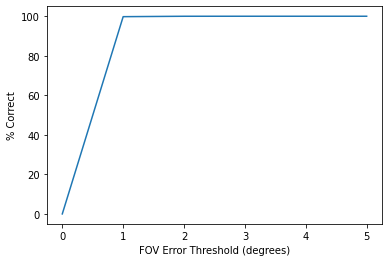

In [7]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 55524

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [8]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 23745, 23794, 23796, 23796, 23796)

In [9]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 0.9978567826525466, 0.9999159522608841, 1.0)

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 1.9435690568003283, 'fy': 1.8801497877873317, 'u0': 0.2296023047417227, 'v0': 0.37571040063891054, 'baseline': 0.29330045409885086, 'disparity': 0.040379390242220085, 'x': 0.3047712246025885, 'y': 0.38303970816175886, 'z': 0.28045512941489203, 'pitch': 1.4408267310215137, 'xworld': 31.613377053173448, 'yworld': 25.092866140117593, 'zworld': 42.71013880363322}


In [15]:
max(output[0])[0]

1124.5992

# Normalization

In [6]:

import math 

def normalize(x):
    
    return (math.atan(x) + 3.14/2) / 3.14

In [7]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.684497496430667, 'fy': 0.6713817717857442, 'u0': 0.5705035358475947, 'v0': 0.6118069484633926, 'baseline': 0.5626533126677936, 'disparity': 0.5113574002642848, 'x': 0.5665639359234423, 'y': 0.5831061090361146, 'z': 0.5675817035001748, 'pitch': 0.7123594741106813, 'xworld': 0.9745200899244825, 'yworld': 0.9819812579767454, 'zworld': 0.9770998745414592}


# Range Normalization

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

min_fx = 1.9073486e-06
max_fx = 3214.9907

min_fy = 2.9563904e-05
max_fy = 2051.209

min_u0 = 1.9073486e-05
max_u0 = 2178.9983

min_v0 = 3.8146973e-06
max_v0 = 2385.7239

min_baseline = 4.7683716e-06
max_baseline = 22.68721567997021

min_disparity = 9.536743e-07
max_disparity = 134.60031

min_tx = 2.384185791015625e-06
max_tx = 22.68721567997021

min_ty = 2.3841858e-07
max_ty = 33.11693576309983

min_tz = 2.3841858e-06
max_tz = 17.20185265614626

min_pitch = 4.57763671875e-05
max_pitch = 4502.9224

min_xw = 5.219264654243716e-06
max_xw = 386.4486

min_yw = 3.8146973e-06
max_yw = 1835.1849

min_zw = 0.00011349
max_zw = 339.17166

key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.0006045328123734624, 'fy': 0.000916591329541554, 'u0': 0.00010536181074296743, 'v0': 0.00015748116198789617, 'baseline': 0.012927798122878219, 'disparity': 0.0002999877035648339, 'x': 0.01343350695203612, 'y': 0.011566271694155127, 'z': 0.016303638032724194, 'pitch': 0.0003199657518740856, 'xworld': 0.08180485648251173, 'yworld': 0.01367320664940879, 'zworld': 0.12592455279078085}


# Normalized MAE

In [ ]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 84.70939817976283

mean_fy = 84.70939817976283

mean_u0 = 56.0

mean_v0 = 56.0

mean_baseline = 3.1362834089762988

mean_disparity = 5.6359135359419765

mean_tx = 3.1362834089762988

mean_ty = 3.2890401748192972

mean_tz = 2.8612371827197847

mean_pitch = 84.54614220877458

mean_xw = 31.613377053172897

mean_yw = 25.092866140117593

mean_zw = 42.71013880363322


key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

In [13]:
np.shape(output)

(13, 23796, 1)

In [14]:
k

79320

In [18]:
sum(error.values())

401.2137982147371